In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [13]:
# Load data - Independent variable
df = pd.read_csv('independent.csv')
df = df.drop(columns=['Series Code'])


# Cleaning independent variable
# From wide to long
df_long = pd.melt(df, id_vars=['Country Name', 'Series Name'],
                  var_name='Year', value_name='amount')

# Convert year to int - need to extract just 4 digits
df_long['Year'] = df_long['Year'].str.extract(r'(\d{4})')
df_long = df_long.dropna(subset=['Year'])
df_long['Year'] = df_long['Year'].astype(int) 

# Renaming columns 
df_long = df_long.rename(columns={'Country Name': 'Country', 'Series Name': 'Variable'})

# Keeping Regulatory Quality variable
df_rq = df_long[df_long['Variable'] == 'Regulatory Quality: Estimate']

# Droping and renaming columns
df_rq = df_rq[['Country', 'Year', 'amount']]
df_rq.columns = ['Country', 'Year', 'regulatory_quality']

print(df_rq.head())

          Country  Year regulatory_quality
0     Afghanistan  2002        -1.81154573
1         Albania  2002       -0.311400771
2         Algeria  2002       -0.574951589
3  American Samoa  2002                 ..
4         Andorra  2002        1.422462821


In [14]:
# Load data - Dependent + control variables
df_con = pd.read_csv('controls.csv')
df_con = df_con.drop(columns=['Series Code'])

# Cleaning Dependent + control variables
# From wide to long
df_con_long = pd.melt(df_con, id_vars=['Country Name', 'Series Name'],
                      var_name='Year', value_name='amount')

# Convert year to int - need to extract just 4 digits
df_con_long['Year'] = df_con_long['Year'].str.extract(r'(\d{4})')
df_con_long = df_con_long.dropna(subset=['Year'])
df_con_long['Year'] = df_con_long['Year'].astype(int)

# Renaming columns
df_con_long = df_con_long.rename(columns={'Country Name': 'Country', 'Series Name': 'Variable'})

# Renaming variables
# Renaming varibales in dictionary 
name_map = {
   'Control of Corruption: Estimate':                                        'control_corruption',

    'Government Effectiveness: Estimate':                                     'government_effectiveness',
    'Rule of Law: Estimate':                                                  'rule_of_law',
    'Voice and Accountability: Estimate':                                     'voice_accountability',
    'CPIA business regulatory environment rating (1=low to 6=high)':          'reg_env_rating',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990)': 'co2_emissions',
    'Energy imports, net (% of energy use)':                                  'energy_imports_net_pct',
    'Energy use (kg of oil equivalent) per $1,000 GDP (constant 2021 PPP)':    'energy_use_kg_oil',
    'GDP growth (annual %)':                                                  'gdp_growth',
    'Fossil fuel energy consumption (% of total)':                             'fossil_fuel',
    'Renewable energy consumption (% of total final energy consumption)':      'renewable_energy',
    'Renewable internal freshwater resources, total (billion cubic meters)':   'freshwater_resources',
    'Foreign direct investment, net inflows (BoP, current US$)':               'fdi_inflows'
}

# Replacing names in the dataframe
df_con_long['Variable'] = df_con_long['Variable'].map(name_map).fillna(df_con_long['Variable'])

# Pivot so variables are columns
df_con_wide = df_con_long.pivot(index=['Country', 'Year'], columns='Variable', values='amount').reset_index()

# Reordering columns 

df_con_wide.head()

Variable,Country,Year,co2_emissions,energy_imports_net_pct,energy_use_kg_oil,fdi_inflows,fossil_fuel,freshwater_resources,gdp_growth,reg_env_rating,renewable_energy
0,Afghanistan,2002,-67.75374718,..,..,50000000,..,47.15,28.60000117,..,37.8
1,Afghanistan,2003,-65.50544111,..,..,57800000,..,47.15,8.832277803,..,36.7
2,Afghanistan,2004,-69.44425433,..,..,186900000,..,47.15,1.414117993,..,44.2
3,Afghanistan,2005,-56.66621039,..,..,271000000,..,47.15,11.22971483,..,33.9
4,Afghanistan,2006,-51.80685785,..,..,238000000,..,47.15,5.357403247,2.5,31.9


In [15]:
# Merging data

df_merged = pd.merge(df_con_wide, df_rq, on=['Country', 'Year'], how='left')
df_merged.head()

,Country,Year,co2_emissions,energy_imports_net_pct,energy_use_kg_oil,fdi_inflows,fossil_fuel,freshwater_resources,gdp_growth,reg_env_rating,renewable_energy,regulatory_quality
0,Afghanistan,2002,-67.75374718,..,..,50000000,..,47.15,28.60000117,..,37.8,-1.81154573
1,Afghanistan,2003,-65.50544111,..,..,57800000,..,47.15,8.832277803,..,36.7,-1.463107824
2,Afghanistan,2004,-69.44425433,..,..,186900000,..,47.15,1.414117993,..,44.2,-1.511548996
3,Afghanistan,2005,-56.66621039,..,..,271000000,..,47.15,11.22971483,..,33.9,-1.643440247
4,Afghanistan,2006,-51.80685785,..,..,238000000,..,47.15,5.357403247,2.5,31.9,-1.689468622


In [16]:
# Make a copy to avoid changing the original
df_cleaned = df_merged.copy()

# Convert all object columns (excluding Country) to numeric
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object' and col != 'Country':
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

print(df_cleaned.dtypes)



Country                    object
Year                        int64
co2_emissions             float64
energy_imports_net_pct    float64
energy_use_kg_oil         float64
fdi_inflows               float64
fossil_fuel               float64
freshwater_resources      float64
gdp_growth                float64
reg_env_rating            float64
renewable_energy          float64
regulatory_quality        float64
dtype: object


In [ ]:
# Correlation matrix
df_corr = df_cleaned.drop(columns=['Country']).corr()

fig, ax = plt.subplots(1,1,figsize = (20,15))
sns.heatmap(df_corr, annot = True, fmt = '.2f')
plt.show()


In [ ]:
# Independent v/s dependent variable trends graph
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df_cleaned,
    x='regulatory_quality',
    y='renewable_energy',
    scatter_kws={'alpha':0.5},
    line_kws={'color': 'red'}
)
plt.title('Relationship: Regulatory Quality vs Renewable Energy Use')
plt.xlabel('Regulatory Quality Index')
plt.ylabel('Renewable Energy (% of Total Energy Use)')
plt.tight_layout()
plt.show()

In [ ]:
# Choose a few countries to highlight
selected_countries = ['Germany', 'United States', 'India', 'Brazil']

# Filter data
df_selected = df_cleaned[df_cleaned['Country'].isin(selected_countries)]

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_selected, x='Year', y='renewable_energy', hue='Country')
plt.title('Renewable Energy Trend Over Time')
plt.ylabel('% of Total Energy from Renewables')
plt.xlabel('Year')
plt.tight_layout()
plt.show()


In [17]:
#Checking for  unbalanced panel
missing_by_column = df_cleaned.isnull().mean().sort_values(ascending=False)
print(missing_by_column)

reg_env_rating            0.712082
energy_imports_net_pct    0.425967
energy_use_kg_oil         0.371869
fossil_fuel               0.342617
freshwater_resources      0.271489
renewable_energy          0.140854
fdi_inflows               0.139852
co2_emissions             0.127229
regulatory_quality        0.114406
gdp_growth                0.089160
Country                   0.000000
Year                      0.000000
dtype: float64


In [18]:
# Step 1: After grouping, take the mean across variables per country
missing_rate = missing_per_country.mean(axis=1)

# Step 2: Sort by missing rate and select top 50 with least missingness
top_50_countries = missing_rate.sort_values().head(50).index

# Step 3: Filter your dataset
df_top_50 = df_cleaned[df_cleaned['Country'].isin(top_50_countries)]
for i, country in enumerate(top_50_countries, 1):
    print(f"{i}. {country}")

1. Kenya
2. Lao PDR
3. Uganda
4. Pakistan
5. Rwanda
6. Congo, Rep.
7. Cote d'Ivoire
8. Ghana
9. Honduras
10. Kyrgyz Republic
11. Zambia
12. Nepal
13. Congo, Dem. Rep.
14. Nicaragua
15. Nigeria
16. Senegal
17. Tajikistan
18. Uzbekistan
19. Mozambique
20. Cameroon
21. Zimbabwe
22. Bangladesh
23. Chad
24. Niger
25. Moldova
26. Mongolia
27. Myanmar
28. Bolivia
29. Benin
30. Viet Nam
31. Ethiopia
32. Sri Lanka
33. Tanzania
34. India
35. Georgia
36. Bosnia and Herzegovina
37. Angola
38. Armenia
39. Sudan
40. Azerbaijan
41. Brazil
42. Madagascar
43. Israel
44. Hungary
45. Turkiye
46. Greece
47. Germany
48. Italy
49. Japan
50. Korea, Rep.


In [20]:
# Step 1: Filter df_cleaned to only include the top 50 countries
df_cleaned_top50 = df_cleaned[df_cleaned['Country'].isin(top_50_countries)].copy()

# Optional: check shape
print(df_cleaned_top50.shape)
df_cleaned_top50.head()


(1150, 12)


,Country,Year,co2_emissions,energy_imports_net_pct,energy_use_kg_oil,fdi_inflows,fossil_fuel,freshwater_resources,gdp_growth,reg_env_rating,renewable_energy,regulatory_quality
115,Angola,2002,41.713339,-575.454280,64.619012,1.743504e+09,29.71,148.0,13.665689,NaN,70.8,-1.294135
116,Angola,2003,54.305609,-520.181045,67.501835,3.576972e+09,33.99,148.0,2.990000,NaN,65.6,-1.187467
117,Angola,2004,57.517341,-590.353278,61.288591,2.197228e+09,33.33,148.0,10.950000,NaN,62.3,-1.226714
118,Angola,2005,39.251338,-812.883915,50.033558,-1.303837e+09,27.83,148.0,15.030000,2.0,68.9,-1.240036
119,Angola,2006,45.317745,-818.589834,50.134753,-3.771486e+07,33.94,148.0,11.550000,2.0,62.6,-1.156216


In [21]:
# Define mapping (from World Bank income groups)
income_group_mapping = {
    'Germany': 'High income', 'Israel': 'High income', 'Italy': 'High income',
    'Japan': 'High income', 'Korea, Rep.': 'High income', 'Greece': 'High income',
    'Hungary': 'High income',
    'Brazil': 'Upper middle income', 'Turkiye': 'Upper middle income', 
    'Bosnia and Herzegovina': 'Upper middle income', 'Azerbaijan': 'Upper middle income',
    'Armenia': 'Upper middle income', 'Georgia': 'Upper middle income',
    'Kenya': 'Lower middle income', 'Lao PDR': 'Lower middle income',
    'Uganda': 'Lower middle income', 'Pakistan': 'Lower middle income',
    'Rwanda': 'Lower middle income', 'Congo, Rep.': 'Lower middle income',
    "Cote d'Ivoire": 'Lower middle income', 'Ghana': 'Lower middle income',
    'Honduras': 'Lower middle income', 'Kyrgyz Republic': 'Lower middle income',
    'Zambia': 'Lower middle income', 'Nepal': 'Lower middle income',
    'Nicaragua': 'Lower middle income', 'Nigeria': 'Lower middle income',
    'Senegal': 'Lower middle income', 'Tajikistan': 'Lower middle income',
    'Uzbekistan': 'Lower middle income', 'Mozambique': 'Lower middle income',
    'Cameroon': 'Lower middle income', 'Zimbabwe': 'Lower middle income',
    'Bangladesh': 'Lower middle income', 'Moldova': 'Lower middle income',
    'Mongolia': 'Lower middle income', 'Myanmar': 'Lower middle income',
    'Bolivia': 'Lower middle income', 'Benin': 'Lower middle income',
    'Viet Nam': 'Lower middle income', 'Sri Lanka': 'Lower middle income',
    'Tanzania': 'Lower middle income', 'India': 'Lower middle income',
    'Angola': 'Lower middle income',
    'Chad': 'Low income', 'Niger': 'Low income', 'Ethiopia': 'Low income',
    'Sudan': 'Low income', 'Madagascar': 'Low income',
    'Congo, Dem. Rep.': 'Low income'
}


In [22]:
# Map and create new column
df_cleaned_top50['Income_Group'] = df_cleaned_top50['Country'].map(income_group_mapping)

# Check a sample
print(df_cleaned_top50[['Country', 'Income_Group']].drop_duplicates())


                     Country         Income_Group
115                   Angola  Lower middle income
184                  Armenia  Upper middle income
276               Azerbaijan  Upper middle income
345               Bangladesh  Lower middle income
460                    Benin  Lower middle income
529                  Bolivia  Lower middle income
552   Bosnia and Herzegovina  Upper middle income
598                   Brazil  Upper middle income
782                 Cameroon  Lower middle income
874                     Chad           Low income
1012        Congo, Dem. Rep.           Low income
1035             Congo, Rep.  Lower middle income
1081           Cote d'Ivoire  Lower middle income
1472                Ethiopia           Low income
1656                 Georgia  Upper middle income
1679                 Germany          High income
1702                   Ghana  Lower middle income
1748                  Greece          High income
1955                Honduras  Lower middle income


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Define the order manually for ordinal encoding
income_order = [['Low income', 'Lower middle income', 'Upper middle income', 'High income']]

# Initialize encoder
ordEnc = OrdinalEncoder(categories=income_order)

# Apply ColumnTransformer
ct = ColumnTransformer(
    transformers=[
        ('ord', ordEnc, ['Income_Group'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Fit and transform
X_trans = ct.fit_transform(df_cleaned_top50)

# Convert to DataFrame
encoded_feature_names = ct.get_feature_names_out()
df_encoded_final = pd.DataFrame(X_trans, columns=encoded_feature_names)

# Check
df_encoded_final.head(100)


,Income_Group,Country,Year,co2_emissions,energy_imports_net_pct,energy_use_kg_oil,fdi_inflows,fossil_fuel,freshwater_resources,gdp_growth,reg_env_rating,renewable_energy,regulatory_quality
0,1.0,Angola,2002,41.713339,-575.45428,64.619012,1743504000.0,29.71,148.0,13.665689,NaN,70.8,-1.294135
1,1.0,Angola,2003,54.305609,-520.181045,67.501835,3576971780.0,33.99,148.0,2.99,NaN,65.6,-1.187467
2,1.0,Angola,2004,57.517341,-590.353278,61.288591,2197227820.0,33.33,148.0,10.95,NaN,62.3,-1.226714
3,1.0,Angola,2005,39.251338,-812.883915,50.033558,-1303836930.0,27.83,148.0,15.03,2.0,68.9,-1.240036
4,1.0,Angola,2006,45.317745,-818.589834,50.134753,-37714860.0,33.94,148.0,11.55,2.0,62.6,-1.156216
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,Benin,2005,605.338706,35.847037,112.68776,-8788860.127,31.05,10.3,1.713165,4.0,59.2,-0.641529
96,1.0,Benin,2006,871.568874,39.107901,127.919696,-12363482.36,36.32,10.3,3.943739,3.5,57.3,-0.461876
97,1.0,Benin,2007,1007.227399,41.801795,131.222185,139189943.0,39.66,10.3,5.986349,3.5,54.5,-0.506434
98,1.0,Benin,2008,998.992697,42.256518,127.87624,48210757.85,39.07,10.3,4.896577,3.5,54.8,-0.554606


In [29]:
# For our baseline,  we start with elastic net regression
# Defining X and y
# Drop rows with any NaN
df_encoded_final_na = df_encoded_final.dropna()
X = df_encoded_final_na.drop(columns=['renewable_energy', 'Country',])  # features
y = df_encoded_final_na['renewable_energy']                 # target


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [52]:
df_encoded_final['Income_Group'].unique()

array([1.0, 2.0, 0.0, 3.0], dtype=object)

In [31]:
#basic linear regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
from sklearn.metrics import mean_squared_error, r2_score
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_lr))
print("Linear Regression R^2:", r2_score(y_test, y_pred_lr))




Linear Regression MSE: 82.55625054036845
Linear Regression R^2: 0.8663830373170461


In [32]:
# Elastic Net Regression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]  # try light Lasso, balanced, strong Lasso
}

elasticnet = ElasticNet(max_iter=10000)  # high max_iter helps avoid convergence issues

grid_search = GridSearchCV(estimator=elasticnet,
                           param_grid=param_grid,
                           cv=5,
                           scoring='r2',
                           verbose=1)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=ElasticNet(max_iter=10000),
             param_grid={'alpha': [0.01, 0.1, 1, 10],
                         'l1_ratio': [0.1, 0.5, 0.9]},
             scoring='r2', verbose=1)

In [33]:
best_elastic = grid_search.best_estimator_
y_pred_elastic = best_elastic.predict(X_test_scaled)

print("Best Parameters:", grid_search.best_params_)
print("R² Score:", r2_score(y_test, y_pred_elastic))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_elastic))


Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.9}
R² Score: 0.8665622708669445
Mean Squared Error: 82.44550973655484


In [34]:
# Trying random forest regression for   non-linear relationships
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("R2 (Random Forest):", r2_score(y_test, y_pred_rf))


R2 (Random Forest): 0.9783721822670858


In [35]:
# Adding Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestRegressor(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf,
                               param_grid=param_grid,
                               cv=5,
                               scoring='r2',
                               verbose=1,
                               n_jobs=-1)  # Use all available cores

grid_search_rf.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='r2', verbose=1)

In [36]:
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Best Parameters:", grid_search_rf.best_params_)
print("R² Score:", r2_score(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R² Score: 0.9780761622595685
MSE: 13.545808892543786


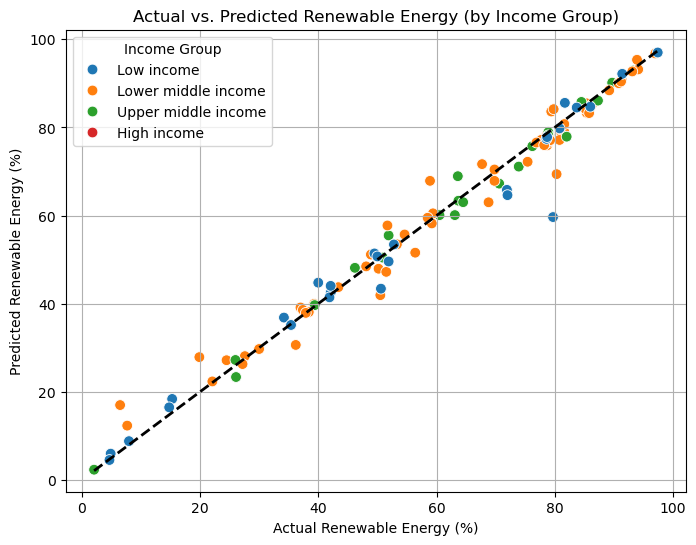

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reseting index
y_test = y_test.reset_index(drop=True)
y_pred_rf = pd.Series(y_pred_rf).reset_index(drop=True)

# Getting country names from test set
countries_test = df_encoded_final_na.loc[y_test.index, 'Country'].reset_index(drop=True)

#Mapping country to income group
income_map = df_cleaned_top50.set_index('Country')['Income_Group'].to_dict()
income_test = countries_test.map(income_map)

# Defining full income group order
income_order = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

# Creating results DataFrame
results = pd.DataFrame({
    'y_actual': y_test,
    'y_predicted': y_pred_rf,
    'Income_Group': pd.Categorical(income_test, categories=income_order, ordered=True)
})

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=results,
    x='y_actual',
    y='y_predicted',
    hue='Income_Group',
    palette='tab10',
    s=60,
    hue_order=income_order
)

min_val = min(results['y_actual'].min(), results['y_predicted'].min())
max_val = max(results['y_actual'].max(), results['y_predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

plt.xlabel('Actual Renewable Energy (%)')
plt.ylabel('Predicted Renewable Energy (%)')
plt.title('Actual vs. Predicted Renewable Energy (by Income Group)')
plt.grid(True)
plt.legend(title='Income Group')
plt.show()
